① EDA 및 전처리   
- 작가별 작품 수 확인   
- 이미지 해상도 및 채널 수 확인   
- 클래스 라벨 인코딩   
- train/val 나누기

② 이미지 전처리   
- ImageDataGenerator   
- 사이즈 통일   
- 정규화   

③ 모델 학습   
- CNN (optimizer=Adam)

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"  # Mac 기본 한글 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

train_df['img_path'] = train_df['id'].apply(
    lambda x: '/Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_Train/Dacon_art/train/' + str(x) + '.jpg'
)

test_df['img_path'] = test_df['id'].apply(
    lambda x: '/Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_Train/Dacon_art/test/' + str(x) + '.jpg'
)

print(train_df.shape)
print(train_df.head(10))
print('---------------')
print(test_df.shape)
print(test_df.head(10))

(5911, 3)
   id                                           img_path  \
0   0  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
1   1  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
2   2  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
3   3  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
4   4  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
5   5  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
6   6  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
7   7  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
8   8  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   
9   9  /Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_...   

                  artist  
0        Diego Velazquez  
1       Vincent van Gogh  
2           Claude Monet  
3            Edgar Degas  
4       Hieronymus Bosch  
5  Pierre-Auguste Renoir  
6          Rene Magritte  
7          Rene Magritte  
8           Michelangelo  
9      Peter Paul Rubens  
---------------
(12670, 2)
     

총 작가 수: 50명
artist
Vincent van Gogh         629
Edgar Degas              490
Pablo Picasso            303
Pierre-Auguste Renoir    233
Albrecht Du rer          220
Paul Gauguin             220
Francisco Goya           204
Rembrandt                181
Titian                   173
Marc Chagall             173
Name: count, dtype: int64


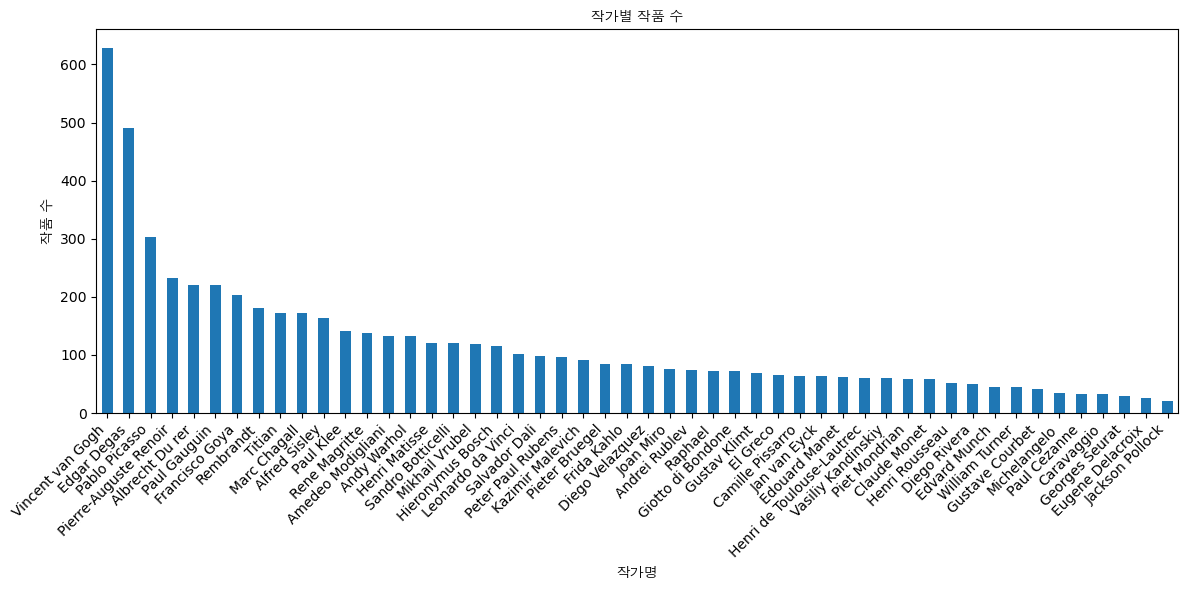

In [3]:
# 작가 수
num_artists = train_df['artist'].nunique()  # nunique(): 고유값의 개수 (작가의 수)
print(f"총 작가 수: {num_artists}명")

# 작가별 작품 수
artist_counts = train_df['artist'].value_counts()
print(artist_counts.head(10))

# 시각화
plt.figure(figsize=(12, 6))
artist_counts.plot(kind='bar')
plt.title('작가별 작품 수', fontproperties=font_prop)
plt.xlabel('작가명', fontproperties=font_prop)
plt.ylabel('작품 수', fontproperties=font_prop)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

상단의 그래프를 보면 **Vincent van Gogh**와 **jackson Pollock**의 작품 수 차이가 크다.   
따라서 클래스 불균형 문제가 나타나, 모델이 많이 나온 작가만 답하려는 경향이 생길 수 있다.   

따라서 이를 해결하기 위해 다음과 같은 방법을 쓰고자 한다.   



**클래스 가중치 적용**

실시간 오버샘플링을 통해 훈련 중에 자동으로 적은 클래스 이미지를 더 자주 학습하는 방식을 사용하고자 한다.   

1. scikit-learn 라이브러리에서 자동으로 클래스 비율 기반 가중치를 계산해주는 코드를 구현하고,

2. 모델 학습 시 class_weight를 적용한다.

In [4]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
le = LabelEncoder()

# 'artist' 컬럼을 숫자로 인코딩해서 'label' 컬럼에 저장
train_df['label'] = le.fit_transform(train_df['artist'])

# 결과 확인
print(train_df[['artist', 'label']].head())

             artist  label
0   Diego Velazquez      9
1  Vincent van Gogh     48
2      Claude Monet      7
3       Edgar Degas     10
4  Hieronymus Bosch     24


In [5]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df,
                                        test_size=0.2,
                                        stratify=train_df['label'],
                                        random_state=42)

print(f"Train size: {train_data.shape}")
print(f"Val size: {val_data.shape}")

Train size: (4728, 4)
Val size: (1183, 4)


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 라벨 인코딩이 되어 있는 경우 (train_data['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['label']),
    y=train_data['label']
)

class_weight_dict = dict(enumerate(class_weights))
print("클래스 가중치:", class_weight_dict)

클래스 가중치: {0: 0.5372727272727272, 1: 0.7218320610687022, 2: 0.8920754716981132, 3: 1.6027118644067797, 4: 0.8920754716981132, 5: 1.8541176470588234, 6: 3.6369230769230767, 7: 2.0119148936170212, 8: 2.364, 9: 1.4547692307692308, 10: 0.24122448979591837, 11: 1.8912, 12: 2.7017142857142855, 13: 1.8184615384615384, 14: 4.502857142857143, 15: 0.5801226993865031, 16: 1.4113432835820896, 17: 3.94, 18: 1.630344827586207, 19: 1.7192727272727273, 20: 2.7811764705882354, 21: 0.9748453608247423, 22: 2.2514285714285713, 23: 1.929795918367347, 24: 1.0278260869565217, 25: 5.562352941176471, 26: 1.8541176470588234, 27: 1.5501639344262295, 28: 1.2953424657534247, 29: 1.1674074074074074, 30: 0.6852173913043478, 31: 3.502222222222222, 32: 1.0059574468085106, 33: 0.3907438016528926, 34: 3.6369230769230767, 35: 0.5372727272727272, 36: 0.8368141592920354, 37: 1.2123076923076923, 38: 0.5083870967741936, 39: 2.0119148936170212, 40: 1.3905882352941177, 41: 1.630344827586207, 42: 0.6521379310344828, 43: 0.859636

#### flow_from_dataframe

**class_mode**: y값(label)을 어떤 형식으로 출력할지   

1. categorical: one-hot encoding
2. sparse: int encoding
3. binary: binary encoding
4. raw: y column 그대로

**subset**: 하나의 폴더(또는 데이터프레임)에서 자동으로 train/val을 나눌 때 어느 쪽을 사용할지   
(직접 train/val을 나눈 경우 사용하지 않아도 됨)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)

# 학습용 데이터 증강
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

# 검증용 데이터는 증강 X
# 모델의 진짜 성능을 평가하기 위한 기준 데이터이기 때문에, 실제와 가장 유사한 원본 이미지 그대로 평가해야 함
val_datagen = ImageDataGenerator(rescale=1./255)

# flow_from_dataframe으로 연결
train_generator = train_datagen.flow_from_dataframe(train_data,
                                                    x_col='img_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_dataframe(val_data,
                                                x_col='img_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)



Found 3931 validated image filenames belonging to 50 classes.
Found 980 validated image filenames belonging to 50 classes.


/opt/miniconda3/envs/apple_tf/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 797 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/opt/miniconda3/envs/apple_tf/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 203 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


### Model

#### 📍 ResNet50

**잔차 연결**을 통해 기울기 손실을 방지하는모델   
⇢ 이전의 입력을 우회시켜 나중 출력에 직접 더해주는 구조

* layers: 약 50개
* input_shape: (224,224,3)   


입력 이미지   
    ↓     
Conv Layer + BatchNorm + ReLU   
    ↓   
[Residual Block] × 16   
    ↓   
GlobalAveragePooling   
    ↓   
Dense (softmax) → 클래스 확률   

파인튜닝하기

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = train_df['label'].nunique()

# Pretrained ResNet50 불러오기 (imagenet weight 사용, 최상단은 제거)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 출력 레이어 구성
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# 전체 모델 정의
model = Model(inputs=base_model.input, outputs=output)

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 확인
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

#### callbacks

1. EarlyStopping: 과적합 방지 조건
- monitor: 멈추기 위한 값의 기준 (검증 손실 등등..)   
- patience: 몇 회 동안 성능이 개선되지 않는지   
- restore_best_weight: 가장 좋았던 시점의 weight로 되돌리기

2. ModelCheckpoint: 제일 좋은 모델 저장
- '__': 모델 저장 파일명   
- monitor: 모델 저장을 위한 값의 기준 (검증 손실 등등..)   
- save_best_only: 최고 성능일 때만 저장 (True)

3. ReduceLROnPlateau: lr 자동 조절
- monitor: lr 자동 조절을 위한 값의 기준 (검증 손실 등등...)   
- patience: 몇 번 동안 개선되지 않는지   
- factor: learning rate를 얼마나 줄일지 (0.5면 절반)   
- min_lr: 하한선 설정

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_resnet50.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict 
)

Epoch 1/30
123/123 [==============================] - 61s 489ms/step - loss: 2.0446 - accuracy: 0.5563 - val_loss: 5.2949 - val_accuracy: 0.0194 - lr: 5.0000e-05
Epoch 2/30
123/123 [==============================] - 59s 476ms/step - loss: 1.2900 - accuracy: 0.6952 - val_loss: 6.1761 - val_accuracy: 0.0286 - lr: 5.0000e-05
Epoch 3/30
123/123 [==============================] - 58s 473ms/step - loss: 0.8796 - accuracy: 0.7718 - val_loss: 5.3102 - val_accuracy: 0.0327 - lr: 5.0000e-05
Epoch 4/30
123/123 [==============================] - 59s 478ms/step - loss: 0.6214 - accuracy: 0.8346 - val_loss: 5.3809 - val_accuracy: 0.0541 - lr: 5.0000e-05
Epoch 5/30
123/123 [==============================] - 59s 476ms/step - loss: 0.4075 - accuracy: 0.8990 - val_loss: 5.2314 - val_accuracy: 0.0918 - lr: 2.5000e-05
Epoch 6/30
123/123 [==============================] - 59s 476ms/step - loss: 0.3418 - accuracy: 0.9089 - val_loss: 4.1546 - val_accuracy: 0.2071 - lr: 2.5000e-05
Epoch 7/30
123/123 [========

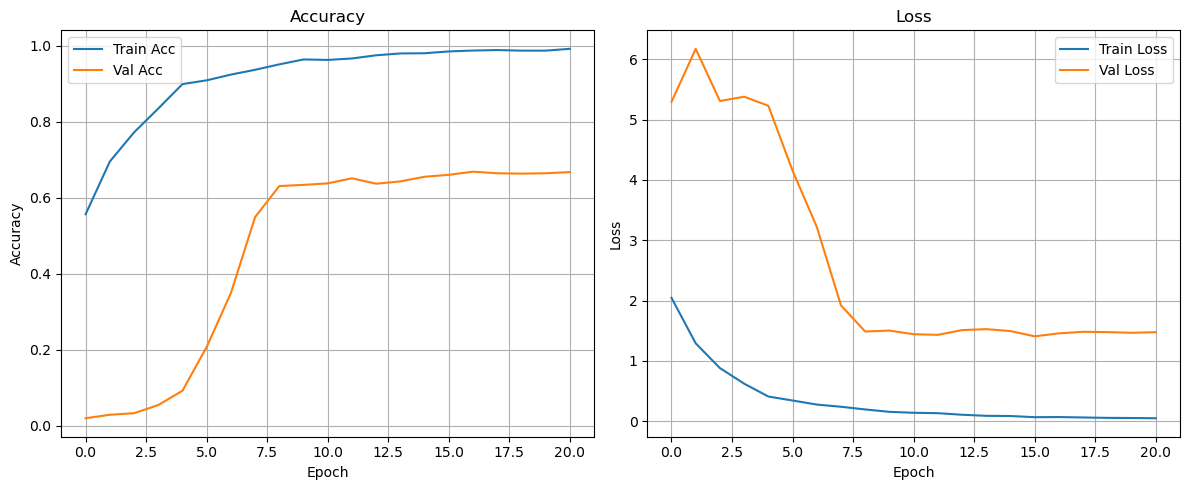

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy 그래프
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

plot_training_history(history)

### Test

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 테스트용: 증강 없음 + shuffle=False (순서 중요!)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',         # 이미지 경로 컬럼
    y_col=None,               # 라벨 없음!
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False             # ← 순서 유지!
)

Found 12670 validated image filenames.


In [22]:
from tensorflow.keras.models import load_model

model = load_model('/Users/kimdohyeon/건양대학교병원_바이오헬스/Biomedical_AI_Train/Dacon_art/best_resnet50.h5')

In [23]:
import numpy as np

pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)  # 클래스 index

2025-04-23 12:00:30.316222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


396/396 [==============================] - 49s 123ms/step


In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df['artist'])

pred_artists = le.inverse_transform(pred_labels)

In [25]:
submission = test_df.copy()
submission['artist'] = pred_artists
submission = submission[['id', 'artist']]
submission.to_csv('submission_result.csv', index=False)

In [31]:
submission['artist'].value_counts()

artist
Rene Magritte                2099
Amedeo Modigliani            1068
Joan Miro                     650
Edvard Munch                  550
Pieter Bruegel                498
Albrecht Du rer               484
Mikhail Vrubel                440
Marc Chagall                  425
Claude Monet                  405
Pierre-Auguste Renoir         358
Eugene Delacroix              341
Henri Matisse                 339
Diego Rivera                  334
Henri Rousseau                312
Paul Cezanne                  300
Raphael                       294
Leonardo da Vinci             291
Edouard Manet                 256
Michelangelo                  252
Georges Seurat                229
Alfred Sisley                 226
Edgar Degas                   186
Hieronymus Bosch              184
Piet Mondrian                 167
Paul Gauguin                  160
Peter Paul Rubens             156
Gustave Courbet               143
Camille Pissarro              115
Pablo Picasso                 105
Henri d

2025-04-23 12:24:38.744966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 5s 129ms/step


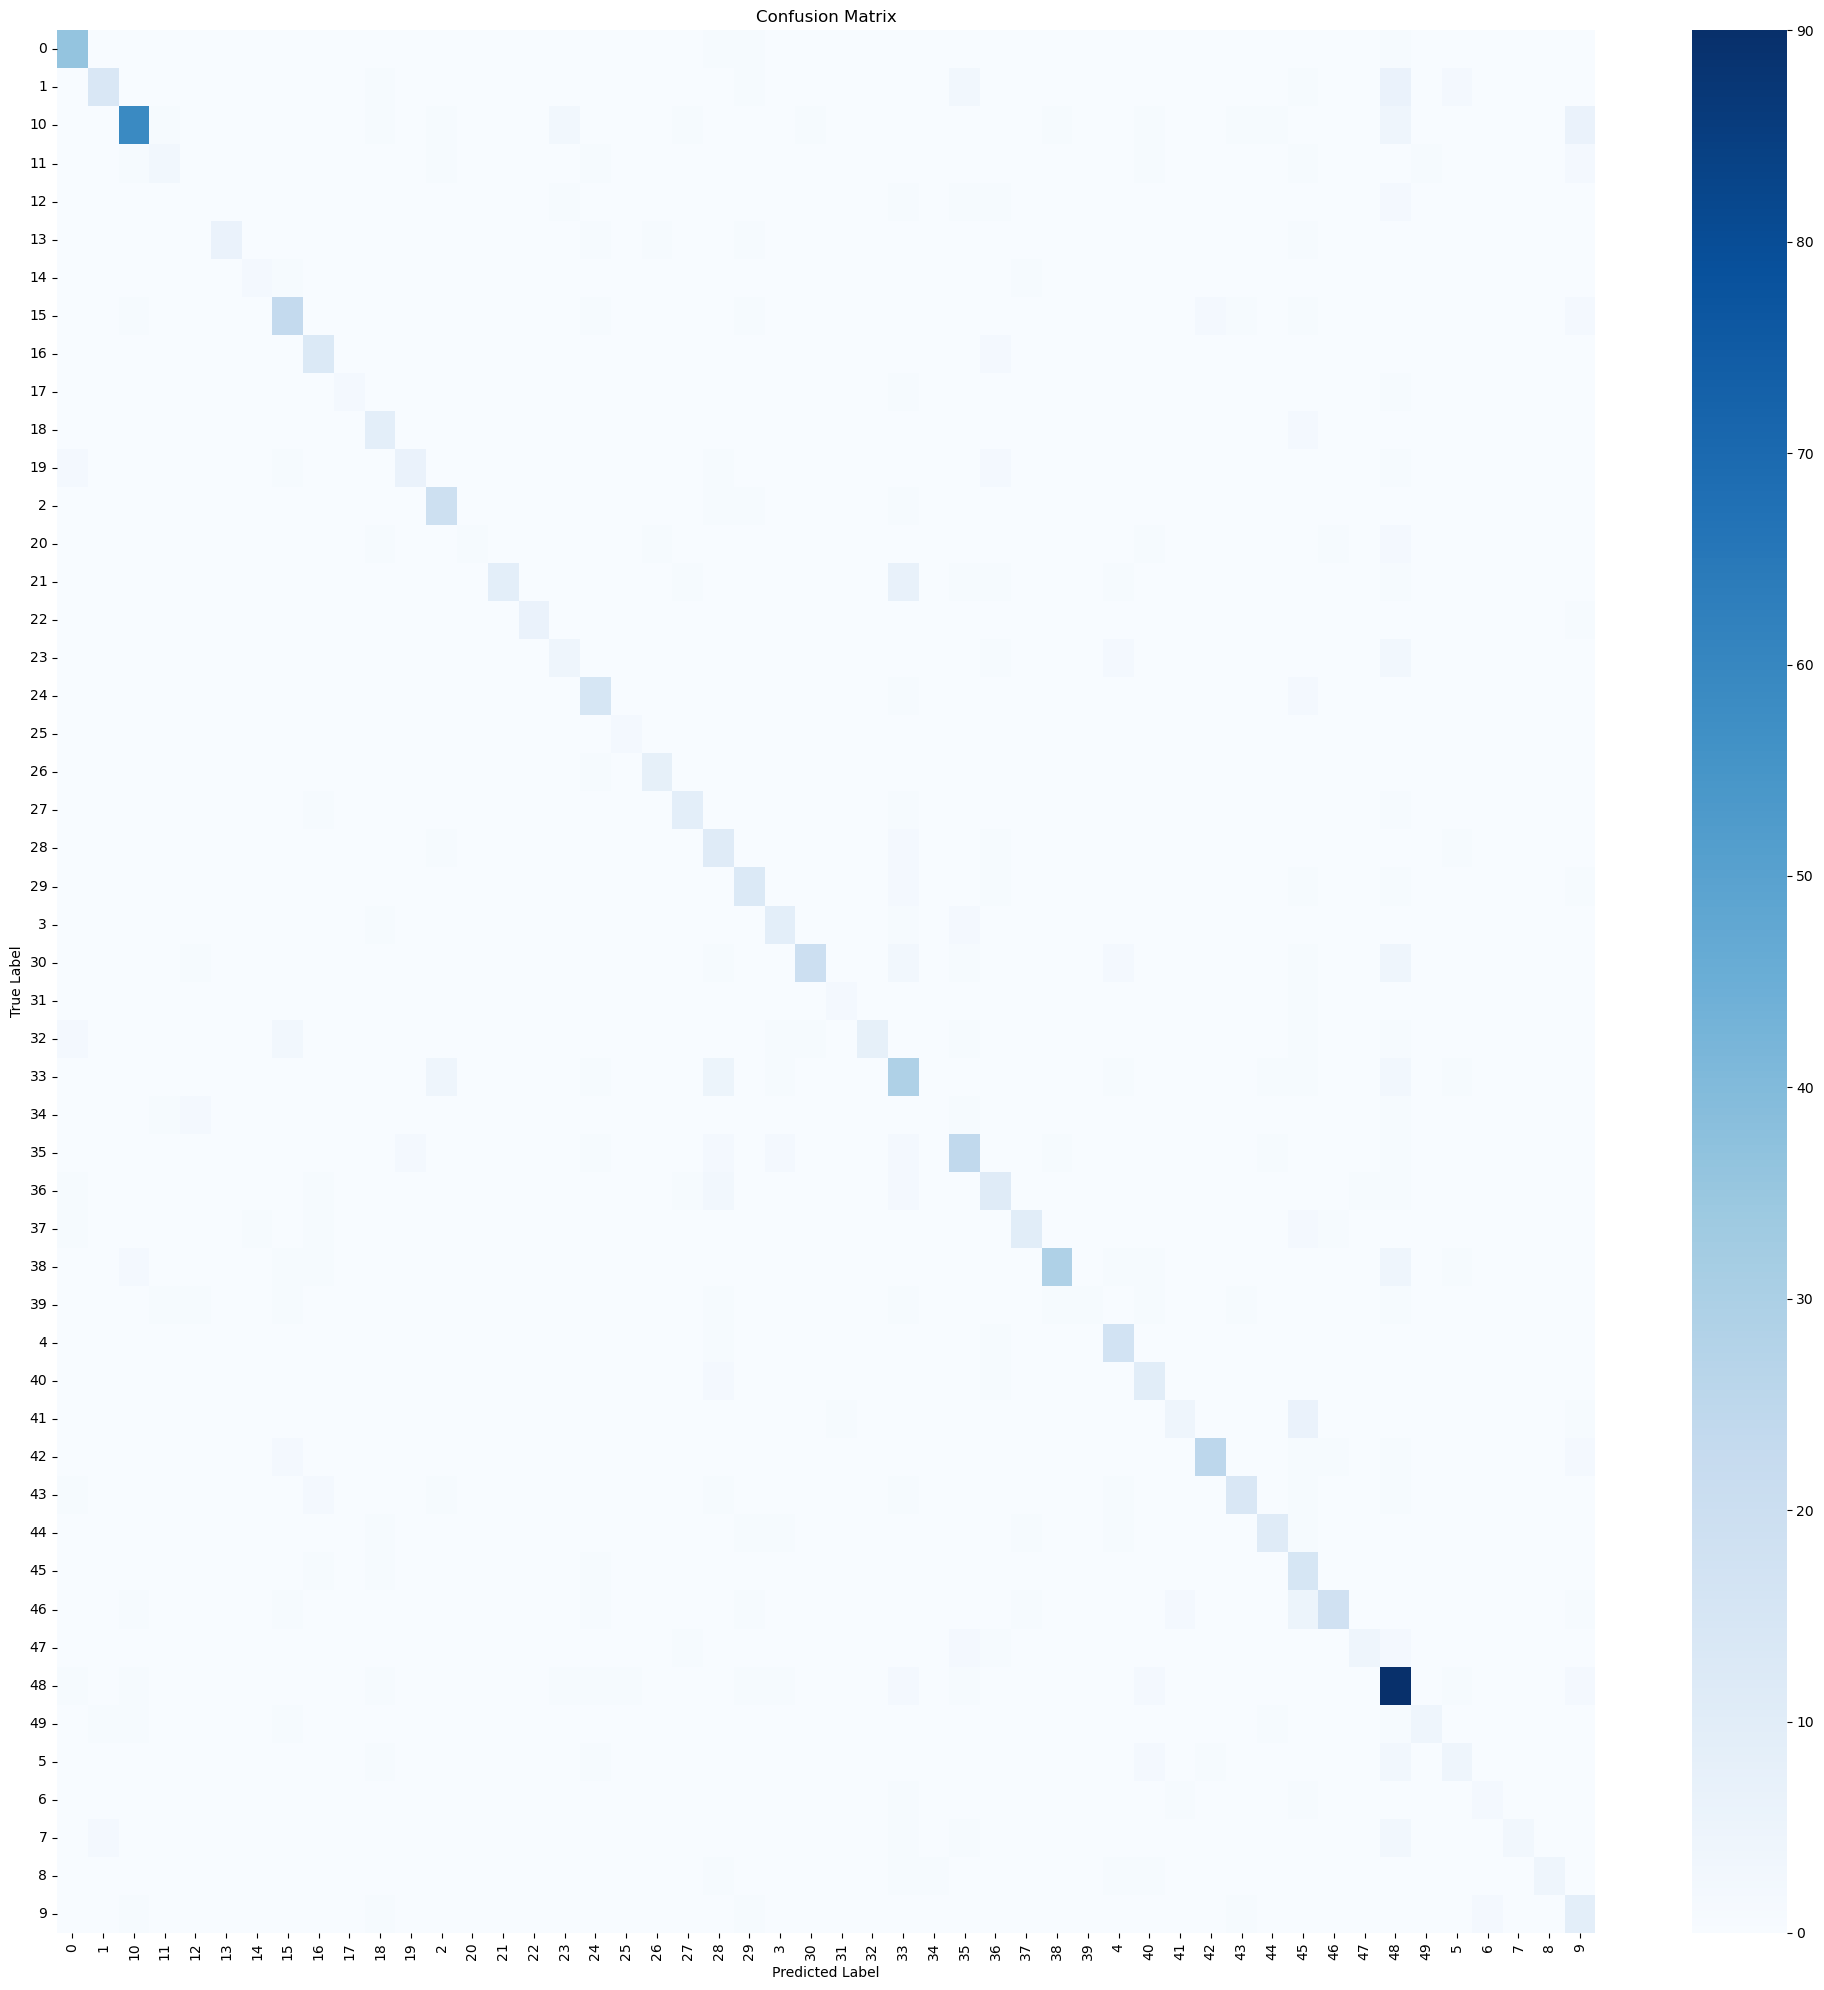

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. 예측
y_true = val_generator.classes  # 실제 라벨
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 라벨

# 2. 클래스 이름 (역순 딕셔너리 활용)
class_labels = list(train_generator.class_indices.keys())

# 3. 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)

# 4. 시각화
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()